In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import ndcg_score
import dask.dataframe as dd
from dask.dataframe import from_pandas
from itertools import combinations
from collections import Counter
from matplotlib.colors import LogNorm, Normalize
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

In [65]:
df_node= pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Erdos_tgbn_2024/data/tgbn-genre_node_labels.csv")
df_node['ts']= pd.to_datetime(df_node['ts'], unit= 's') # timestamp to datetime
df_node['ts'] = pd.to_datetime(df_node['ts'].dt.strftime('%Y-%m-%d')) # dont need time because the timestamp is reset to the beginning of day in order to calculate the frequency vector label
df_node['user_id']=df_node['user_id'].str.slice(5).astype('Int64') #convert user_id to integers
df_node # remember weight is the frequency vector entries, not the actual weight

,ts,user_id,genre,weight
0,2005-02-15,54,chillout,0.015835
1,2005-02-15,54,female vocalist,0.015330
2,2005-02-15,54,downtempo,0.008128
3,2005-02-15,54,electronic,0.072162
4,2005-02-15,54,reggae,0.021465
...,...,...,...,...
2741930,2009-06-12,651,katy perry,0.004864
2741931,2009-06-12,724,bebop,0.041841
2741932,2009-06-12,724,jazz,0.958159
2741933,2009-06-12,802,Britney Spears,0.359504


In [66]:
# Train Validation Test Split
np.quantile(df_node['ts'].unique(), [0.7,0.85]) #70-15-15 split of the timestamps

array(['2008-02-24T14:23:59.999999993', '2008-10-18T07:11:59.999999996'],
      dtype='datetime64[ns]')

In [67]:
train= df_node.loc[df_node['ts']<datetime(2008,2,25)]
val= df_node.loc[(datetime(2008,2,25)<=df_node['ts']) & (df_node['ts']<=datetime(2008,10,18))]
test= df_node.loc[datetime(2008,10,18)<df_node['ts']]

In [68]:
train

,ts,user_id,genre,weight
0,2005-02-15,54,chillout,0.015835
1,2005-02-15,54,female vocalist,0.015330
2,2005-02-15,54,downtempo,0.008128
3,2005-02-15,54,electronic,0.072162
4,2005-02-15,54,reggae,0.021465
...,...,...,...,...
1638965,2008-02-24,995,pop,0.017661
1638966,2008-02-24,995,acoustic,0.146607
1638967,2008-02-24,995,soul,0.088105
1638968,2008-02-24,995,jazz,0.050220


In [69]:
weight_sum=train.groupby(['genre']).agg({'weight':'sum'}).reset_index()
weight_sum.sort_values('weight', ascending=False, inplace=True)
weight_sum

,genre,weight
441,rock,15047.895332
323,indie,12961.928374
169,alternative,7133.614130
260,electronic,6774.317897
326,indie rock,5470.986444
...,...,...
381,motherfuckin rabbits ejaculating sunshine,0.345181
93,Lady Gaga,0.337863
7,2009,0.225832
289,genre,0.199001


In [70]:
top_100_genres= list(weight_sum['genre'].values[:100])

In [71]:
top_100_genres

['rock',
 'indie',
 'alternative',
 'electronic',
 'indie rock',
 'pop',
 'female vocalist',
 'classic rock',
 'alternative rock',
 '80s',
 'punk',
 'metal',
 'folk',
 'dance',
 'Hip-Hop',
 'hard rock',
 'chillout',
 'singer-songwriter',
 'acoustic',
 'new wave',
 'britpop',
 'heavy metal',
 'industrial',
 'jazz',
 'soul',
 'trip hop',
 'Progressive rock',
 'Grunge',
 'instrumental',
 '90s',
 'british',
 '60s',
 'Melodic Death Metal',
 'ambient',
 'thrash metal',
 'death metal',
 'post-punk',
 'punk rock',
 'Progressive metal',
 'reggae',
 'cover',
 'emo',
 'experimental',
 'rap',
 '70s',
 'Gothic Metal',
 'House',
 'country',
 'indie pop',
 'rnb',
 'shoegaze',
 'post rock',
 'black metal',
 'psychedelic',
 'symphonic metal',
 'hardcore',
 'electro',
 'electronica',
 'doom metal',
 'funk',
 'Soundtrack',
 'hip hop',
 'blues',
 'piano',
 'industrial metal',
 'trance',
 'ska',
 'Power metal',
 'oldies',
 'Alt-country',
 'metalcore',
 'Psychedelic Rock',
 'Stoner Rock',
 'downtempo',
 'sw

In [72]:
top_100_train= train[train['genre'].isin(top_100_genres)].reset_index()
top_100_train

,index,ts,user_id,genre,weight
0,0,2005-02-15,54,chillout,0.015835
1,1,2005-02-15,54,female vocalist,0.015330
2,2,2005-02-15,54,downtempo,0.008128
3,3,2005-02-15,54,electronic,0.072162
4,4,2005-02-15,54,reggae,0.021465
...,...,...,...,...,...
1298823,1638965,2008-02-24,995,pop,0.017661
1298824,1638966,2008-02-24,995,acoustic,0.146607
1298825,1638967,2008-02-24,995,soul,0.088105
1298826,1638968,2008-02-24,995,jazz,0.050220


In [73]:
dt=top_100_train.groupby(['ts', 'user_id'])['genre'].apply(list).reset_index() #making the list of genres for each user
dt

,ts,user_id,genre
0,2005-02-15,54,"[chillout, female vocalist, downtempo, electro..."
1,2005-02-15,174,"[90s, dance, pop, instrumental, indie pop, ind..."
2,2005-02-15,235,"[indie, acoustic, alternative, beautiful, folk..."
3,2005-02-15,293,"[symphonic metal, rnb, pop, Soundtrack, rock, ..."
4,2005-02-15,298,"[indie, Soundtrack, female vocalist, british, ..."
...,...,...,...
155139,2008-02-24,963,"[soul, funk, french, folk, jazz, female vocali..."
155140,2008-02-24,978,"[pop, female vocalist, piano, Grunge, rock, 90..."
155141,2008-02-24,980,"[electronic, indie, indie rock, british, rock,..."
155142,2008-02-24,993,"[indie rock, indie, trip hop, dance, folk, ins..."


In [74]:
lit=[list(combinations(item, r=2)) for item in dt['genre'].values] #this makes unordered tuples of the genres in each list
flat_lit=[item for items in lit for item in items] #flatten the list

In [75]:
count= Counter(flat_lit)
count

Counter({('chillout', 'female vocalist'): 3865,
         ('chillout', 'downtempo'): 4122,
         ('chillout', 'electronic'): 4876,
         ('chillout', 'reggae'): 1131,
         ('chillout', 'dance'): 2856,
         ('chillout', 'lounge'): 2581,
         ('chillout', 'soul'): 1870,
         ('chillout', 'funk'): 1307,
         ('chillout', 'indie'): 3780,
         ('chillout', 'alternative rock'): 3346,
         ('chillout', 'Gothic Rock'): 403,
         ('chillout', 'britpop'): 1971,
         ('chillout', 'rock'): 4006,
         ('chillout', 'classic rock'): 2817,
         ('chillout', '80s'): 2821,
         ('chillout', 'synth pop'): 703,
         ('chillout', 'pop'): 3245,
         ('chillout', 'hard rock'): 1293,
         ('chillout', 'alternative'): 4228,
         ('chillout', 'punk'): 1570,
         ('chillout', 'glam rock'): 345,
         ('chillout', 'Hip-Hop'): 1954,
         ('chillout', 'rap'): 1160,
         ('chillout', 'punk rock'): 1122,
         ('chillout', 'Stoner 

In [76]:
dictionary= dict(zip(sorted(top_100_genres),range(100))) #sort the genres and make a map from genres to numbers
dictionary

{'60s': 0,
 '70s': 1,
 '80s': 2,
 '90s': 3,
 'Alt-country': 4,
 'Canadian': 5,
 'Coldplay': 6,
 'Disco': 7,
 'Electroclash': 8,
 'Garage Rock': 9,
 'Gothic Metal': 10,
 'Gothic Rock': 11,
 'Grunge': 12,
 'Hip-Hop': 13,
 'House': 14,
 'Mellow': 15,
 'Melodic Death Metal': 16,
 'Nu Metal': 17,
 'Power metal': 18,
 'Progressive metal': 19,
 'Progressive rock': 20,
 'Psychedelic Rock': 21,
 'Soundtrack': 22,
 'Stoner Rock': 23,
 'acoustic': 24,
 'alternative': 25,
 'alternative rock': 26,
 'ambient': 27,
 'beautiful': 28,
 'black metal': 29,
 'blues': 30,
 'british': 31,
 'britpop': 32,
 'chillout': 33,
 'classic rock': 34,
 'country': 35,
 'cover': 36,
 'dance': 37,
 'death metal': 38,
 'doom metal': 39,
 'downtempo': 40,
 'dream pop': 41,
 'electro': 42,
 'electronic': 43,
 'electronica': 44,
 'emo': 45,
 'experimental': 46,
 'female vocalist': 47,
 'finnish': 48,
 'folk': 49,
 'folk metal': 50,
 'french': 51,
 'funk': 52,
 'glam rock': 53,
 'hard rock': 54,
 'hardcore': 55,
 'heavy meta

In [77]:
keys=[]
for item in count.keys():
  keys.append((dictionary[item[0]], dictionary[item[1]]))

In [78]:
new_dict= dict(zip(keys,count.values()))

In [79]:
new_dict

{(33, 47): 3865,
 (33, 40): 4122,
 (33, 43): 4876,
 (33, 85): 1131,
 (33, 37): 2856,
 (33, 69): 2581,
 (33, 91): 1870,
 (33, 52): 1307,
 (33, 60): 3780,
 (33, 26): 3346,
 (33, 11): 403,
 (33, 32): 1971,
 (33, 87): 4006,
 (33, 34): 2817,
 (33, 2): 2821,
 (33, 94): 703,
 (33, 76): 3245,
 (33, 54): 1293,
 (33, 25): 4228,
 (33, 82): 1570,
 (33, 53): 345,
 (33, 13): 1954,
 (33, 84): 1160,
 (33, 83): 1122,
 (33, 23): 479,
 (33, 70): 1112,
 (33, 56): 645,
 (47, 40): 1736,
 (47, 43): 8462,
 (47, 85): 2049,
 (47, 37): 5158,
 (47, 69): 1187,
 (47, 91): 4363,
 (47, 52): 2251,
 (47, 60): 8193,
 (47, 26): 7543,
 (47, 11): 1079,
 (47, 32): 4502,
 (47, 87): 8757,
 (47, 34): 6390,
 (47, 2): 6683,
 (47, 94): 1422,
 (47, 76): 7529,
 (47, 54): 2999,
 (47, 25): 9944,
 (47, 82): 3657,
 (47, 53): 1073,
 (47, 13): 3336,
 (47, 84): 2107,
 (47, 83): 2637,
 (47, 23): 829,
 (47, 70): 2473,
 (47, 56): 1517,
 (40, 43): 1617,
 (40, 85): 377,
 (40, 37): 824,
 (40, 69): 1381,
 (40, 91): 661,
 (40, 52): 523,
 (40, 60)

In [80]:
M= [[0]*100 for i in range(100)]
for key, value in new_dict.items():
  M[key[0]][key[1]]+= value

In [81]:
M=np.array(M)
M= M+M.transpose()

In [82]:
top_100_genres= sorted(top_100_genres)

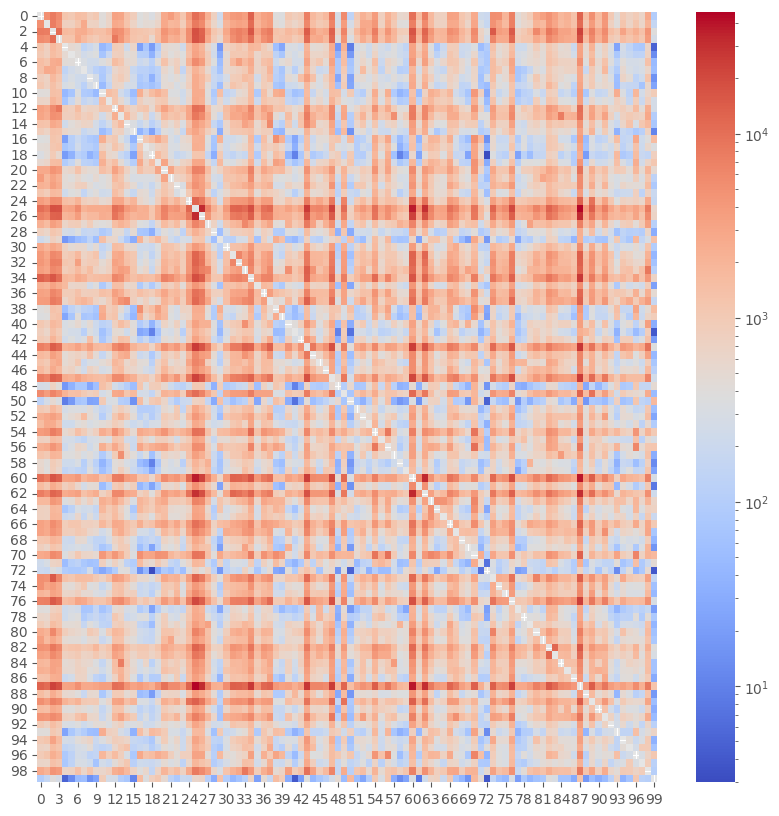

In [83]:
plt.figure(figsize=(10,10))
ax= sns.heatmap(M,cmap = 'coolwarm', norm=LogNorm())
plt.show()

In [84]:
from scipy.linalg import logm, expm

In [85]:
M[0]

array([    0,  5063,  7826,  5692,  1213,  1042,  1521,  1404,   876,
        1095,   399,   673,  3348,  3089,  1311,   864,   358,   461,
         325,   538,  2724,  3829,  2201,  1170,  3776, 10137,  7126,
        2258,   784,   213,  2726,  4015,  4387,  3605, 13267,  2323,
        3376,  3721,   384,   344,  1085,   817,   997,  7216,  1782,
        1258,  1745,  7840,   277,  5660,   134,  1037,  2241,  1570,
        3889,   790,  2205,  1277,   549,   586,  9903,  1608,  7614,
        1782,   770,   767,  3317,  3200,  1161,   834,  2699,   226,
         199,  5324,  5006,  1977,  7204,   412,   612,   933,  2567,
        3514,  4890,  3383,  1932,  2301,  1280, 12885,  1558,  5176,
        1603,  4559,  1029,   406,  1049,   733,   950,   636,  2616,
          99])

In [86]:
M_tran=[]

In [87]:
for lit in M:
  new=[]
  for item in lit:
    if item==0:
      new.append(0)
    else:
      new.append(np.log10(item))
  M_tran.append(new)

In [88]:
M_tran[0]

[0,
 3.704407927386841,
 3.8935398435646613,
 3.7552648914122466,
 3.083860800866573,
 3.0178677189635055,
 3.182129214052998,
 3.1473671077937864,
 2.9425041061680806,
 3.0394141191761372,
 2.6009728956867484,
 2.828015064223977,
 3.5247854493212225,
 3.4898179083014504,
 3.117602691690084,
 2.936513742478893,
 2.5538830266438746,
 2.663700925389648,
 2.5118833609788744,
 2.7307822756663893,
 3.4352071032407476,
 3.583085366347688,
 3.342620042553348,
 3.0681858617461617,
 3.5770319856260313,
 4.005909446494559,
 3.852845818014997,
 3.353723937588949,
 2.8943160626844384,
 2.3283796034387376,
 3.435525851498655,
 3.6036855496146996,
 3.642167634404945,
 3.5569052690554477,
 4.122772729138599,
 3.3660492098002353,
 3.5284024379536176,
 3.5706596700215343,
 2.584331224367531,
 2.53655844257153,
 3.0354297381845483,
 2.9122220565324155,
 2.998695158311656,
 3.8582965245338854,
 3.250907699700856,
 3.0996806411092503,
 3.241795431295199,
 3.8943160626844384,
 2.4424797690644486,
 3.752816

In [89]:
!pip install adjustText

In [90]:
two_d

array([[-3.32099532,  0.48000298],
       [-3.32099532,  0.48000298],
       [-3.32099532,  0.48000298],
       ...,
       [ 3.21486767,  0.43726072],
       [-2.4417821 ,  0.57540553],
       [ 8.94845007, -3.76424875]])

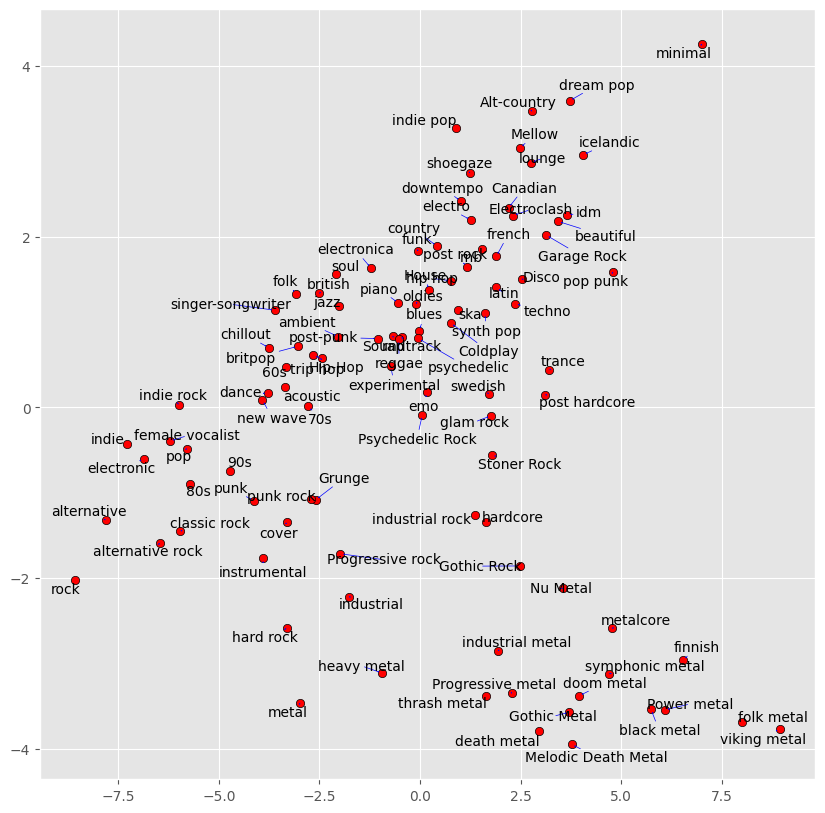

In [91]:
from adjustText import adjust_text
plt.style.use('ggplot')
two_d = PCA().fit_transform(M_tran)[:,:2]
plt.figure(figsize=(10,10))
plt.scatter(two_d[:,0], two_d[:,1], edgecolors='k', c ='r')
texts = [plt.text(two_d[i][0], two_d[i][1], top_100_genres[i], ha='center', va='center') for i in range(100)]
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='blue'))